In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(18,10)})

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, roc_auc_score, cohen_kappa_score, matthews_corrcoef

The data for the project is stored in a google drive folder. To access it, the drive is mounted on colab and the dataset is read with `pandas.read_csv()` function.

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
df = pd.read_csv('/content/drive/MyDrive/datasets/Crop_recommendation.csv')

The shape of the dataset before processing is 8 columns and 2200 samples.

In [59]:
df.shape

(2200, 8)

In [60]:
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


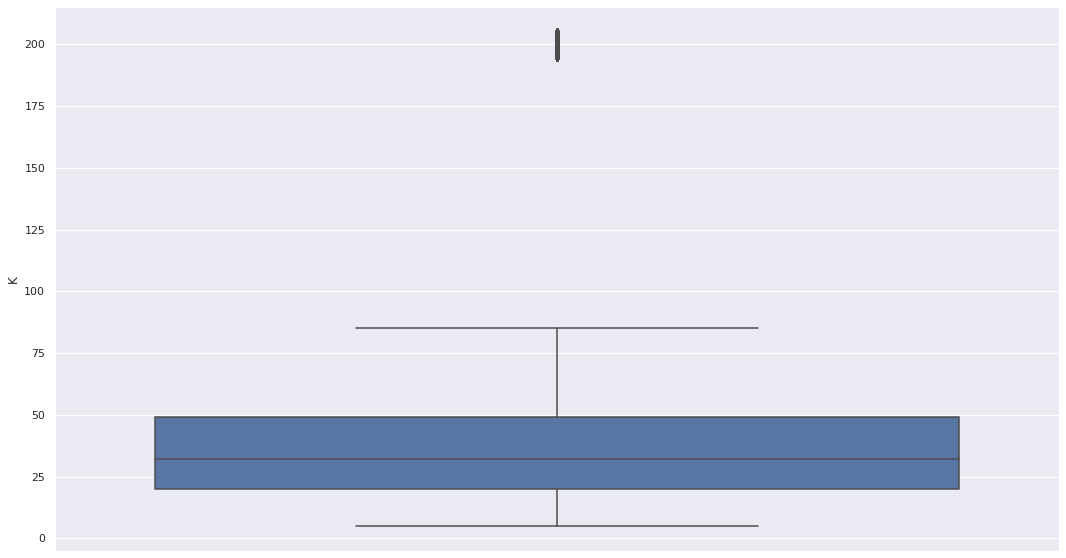

In [61]:
sns.boxplot(y=df['K'])

Comment: From the boxplot above, it is clearly visible that the data contains some outliers which need to filtered out to get better results. I have used the IQR method for removing the outliers in the data. The function to perform this operation is defined in the cell below.

In [62]:
def remove_outlier_IQR(df, cols):
  '''
  Takes in dataframe to be processed along with the columns on which outlier 
  removal operation is performed. 
  Returns a dataframe with outliers removed for specified columns.
  '''

  for col in cols:
    Q1=df[col].quantile(0.25)
    Q3=df[col].quantile(0.75)
    IQR=Q3-Q1
    df.drop(df[df[col]<(Q1-1.5*IQR)].index, inplace=True)
    df.drop(df[df[col]>(Q3+1.5*IQR)].index, inplace=True)
  
  return df

In [63]:
cols = list(df.columns)[:-1]
df = remove_outlier_IQR(df, cols)

In [64]:
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
7,94,53,40,20.277744,82.894086,5.718627,241.974195,rice
8,89,54,38,24.515881,83.535216,6.685346,230.446236,rice


After performing the outlier removal from our dataset, the number of samples reduces to 1846. 

In [65]:
df.shape

(1846, 8)

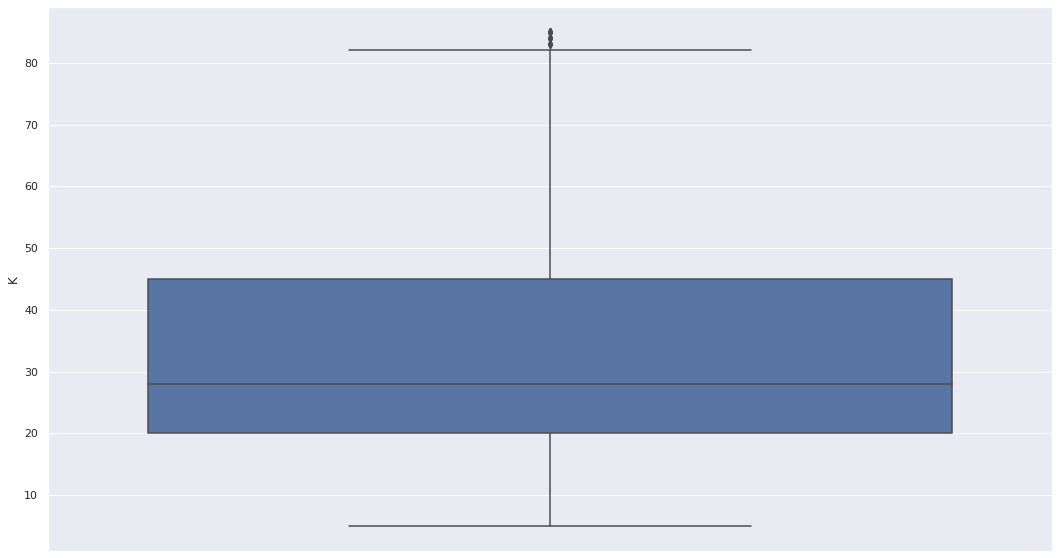

In [66]:
sns.boxplot(y=df['K'])

As it is apparent from the above boxplot, the outliers have been removed and the plot looks less imbalanced than before.

In [67]:
def plot_boxplot(df, feature):
  plt.title(f'Boxplot for values of feature {feature} for all crop types')
  sns.boxplot(x=df['label'], y=df[feature], showmeans=True, meanprops={"markerfacecolor": "black", "markersize": "10"})
  plt.xticks(rotation=45)
  plt.show()

To get a better idea of the overall distribution for all the crops, I have created boxplots for each feature. The black triangle represents the mean/average value of the quantity for a particular crop.



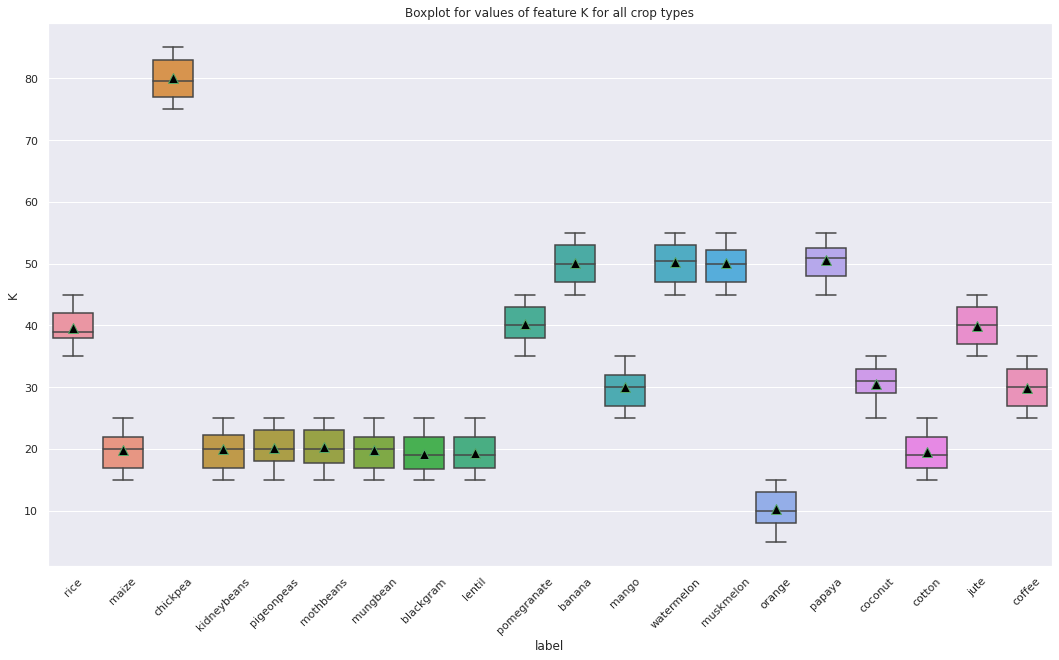

In [68]:
plot_boxplot(df, 'K')

Comments: 
- From the plot above, it can be observed that 'chickpea' require a higher amount of K i.e. potassium for growth than other crops by a large margin. 
- Orange requires the least amount of potassium for production. 
- Another interesting point to observe is that all the crops have a similar range of about 10 units of Potassium required for growth. It means that the no one crop has a higher tolerance to different levels of potassium in the soil.

---


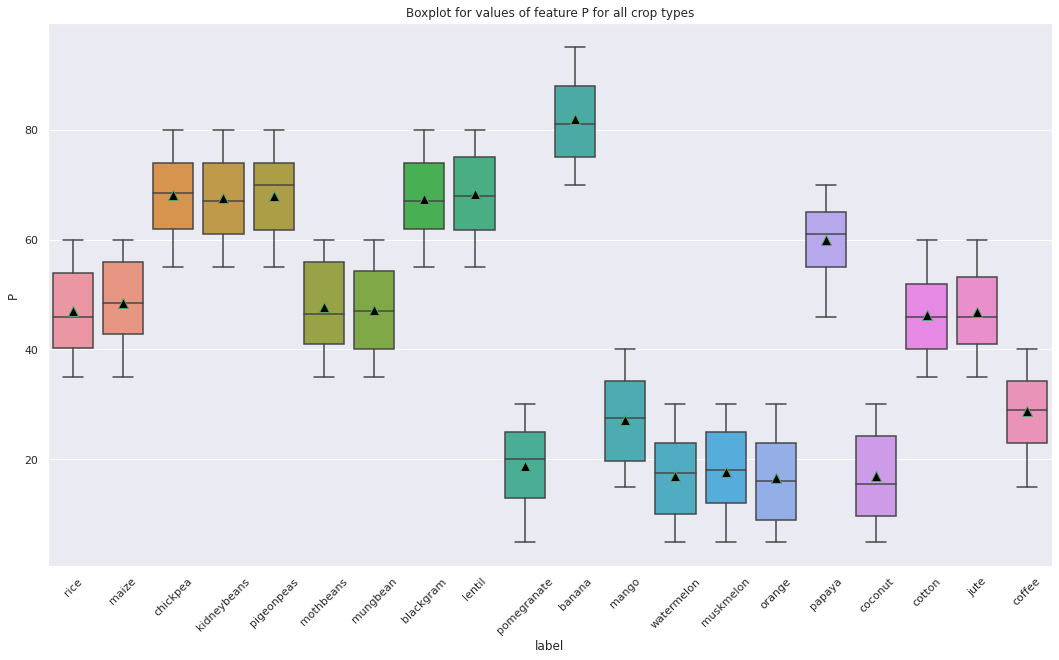

In [69]:
plot_boxplot(df, 'P')

Comments:
- Bananas on average require higher requirement of Phosphorous in the soil than other plants.
- Like the Potassium plot, we also see that almost all crops have a similar range of requirement of Phosphorous level in the soil which is about 25 units.

---




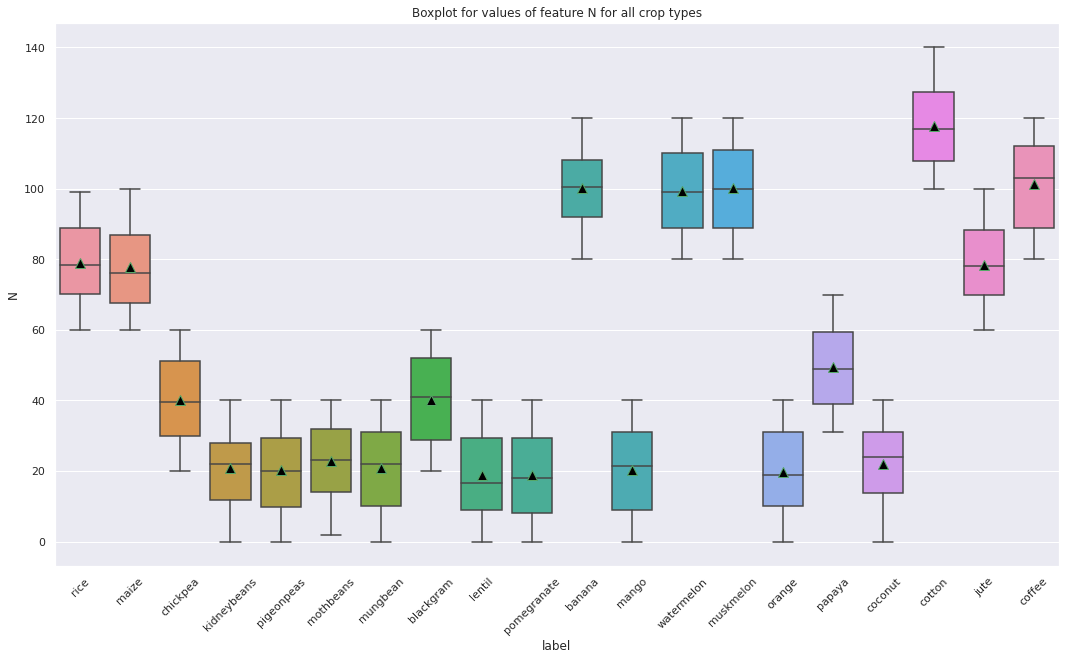

In [70]:
plot_boxplot(df, 'N')

Comments:
- Cotton on average requires the highest amount of Nitrogen in the soil.
- Like the previous two features, crops have a similar range for the requirement of nitrogen in the soil.
- The average value required for half of the crops is about 30 units.

---



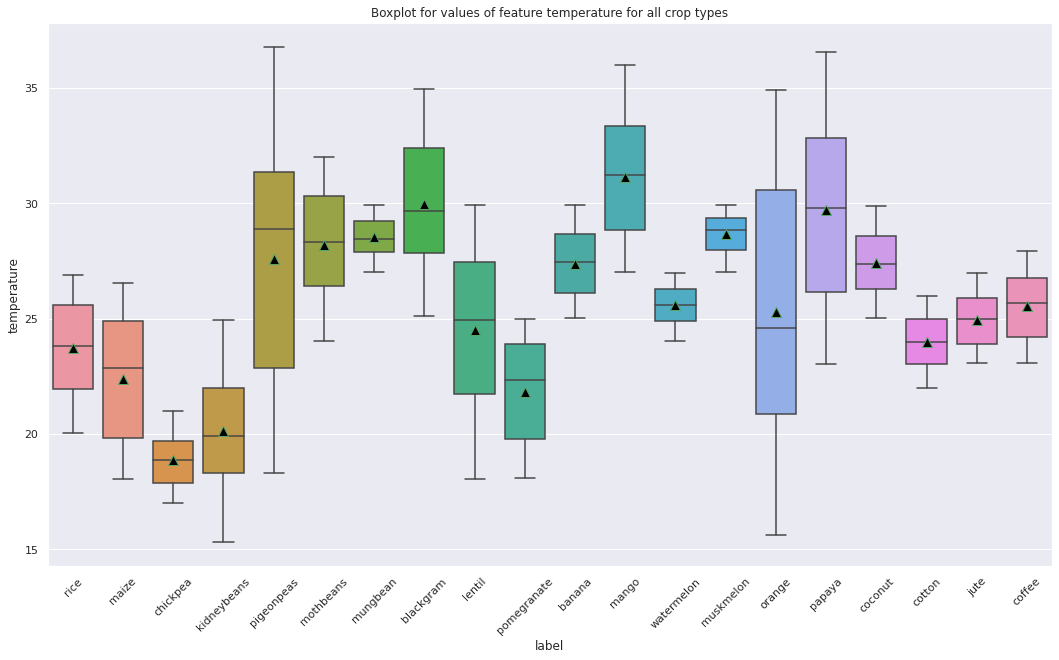

In [71]:
plot_boxplot(df, 'temperature')

Comments: 
- From the plot above, it can be deduced that mungbean, muskmelon and watermelon have the lowest range of tolerance for temperature.
- Oranges and pigeonpeas have the highest range of tolerance for temperature.
- On average, mango requires the highest temperature for growth i.e. 32°C while chickpeas require the least temperature of about 18°C.
---


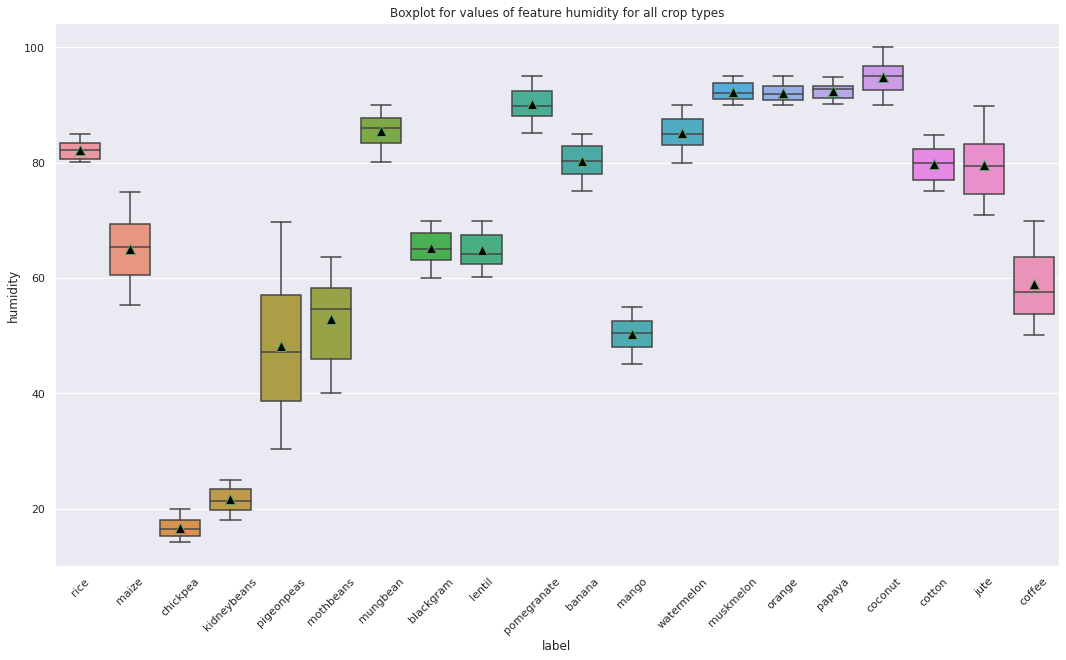

In [72]:
plot_boxplot(df, 'humidity')

Comments:
- Pigeonpeas have the highest range of tolerance for humidity levels in the atmosphere.
- It can be observed that most of the crops have lower value ranges for humidity tolerance.

---



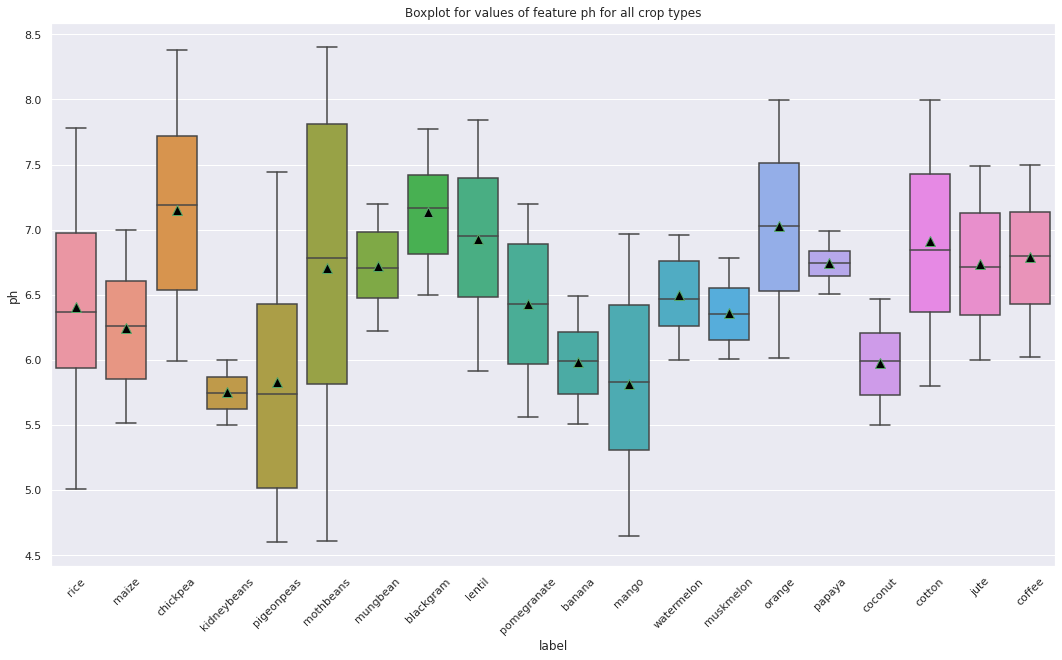

In [73]:
plot_boxplot(df, 'ph')

Comments:
- From the plot above, the average value of pH of soil required seems to about 6.5 for all crops.
- Mothbeans are the most flexible crops that can grow in a vast range of pH values of the soil. They account for both the maximum and minimum values of pH value tolerated.
- Papaya is the most sensitive crop requiring pH values between 6.5 and 7.

---



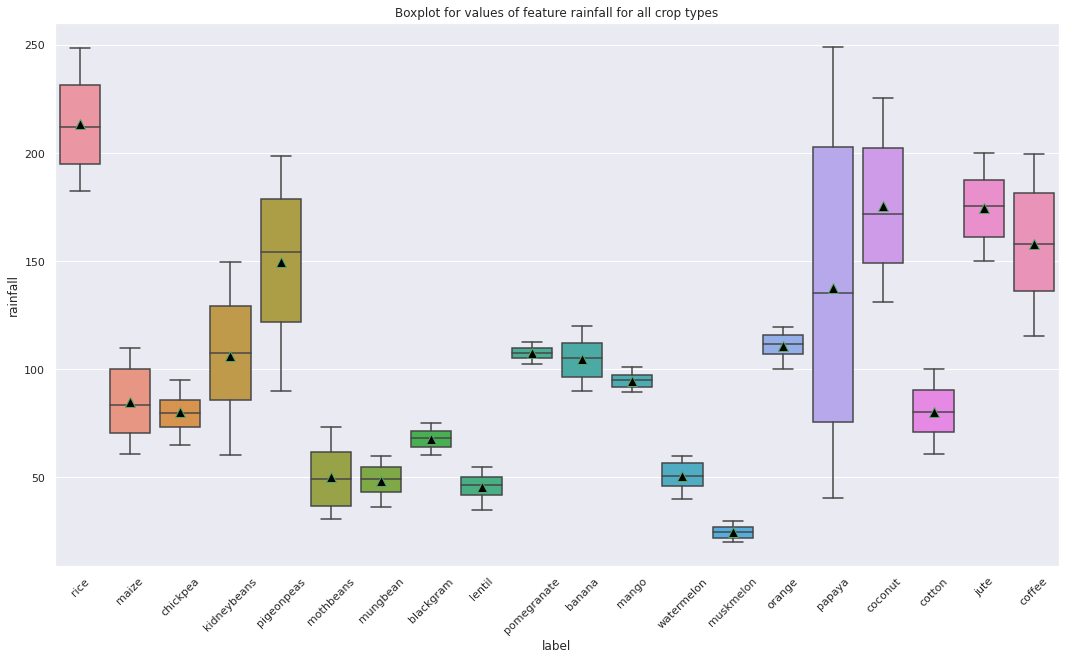

In [74]:
plot_boxplot(df, 'rainfall')

Comments:
- Papaya has the highest range of values for rainfall required for growth with a range of about 200 units.
- Rice, on average requires the most rainfall for it's production. 
- On the other hand, muskmelon requires the least rainfall, on average more than 4 times less than rice.

---



From the boxplots above, it can also be observed that certain crops are more flexible with values for atmospheric conditions i.e. rainfall, humidity, temperature, pH of soil. These factors have much more variation than soil mineral factors like levels of N, K, P.

---



To identify any intrinsic clusters present in the data, I have performed dimensionality reduction from 7 dimensions/features to 2 dimensions using Principal Component Analysis (PCA). This will give a high level view to observe whether any clusters exist in 2D.

In [75]:
x = df.loc[:, cols].values
y = df.loc[:, ['label']].values
x = StandardScaler().fit_transform(x)

In [76]:
pca = PCA(n_components=2)
pca_comps = pca.fit_transform(x)
pca_df = pd.DataFrame(pca_comps, columns=['pc1', 'pc2'])
pca_df['label'] = y

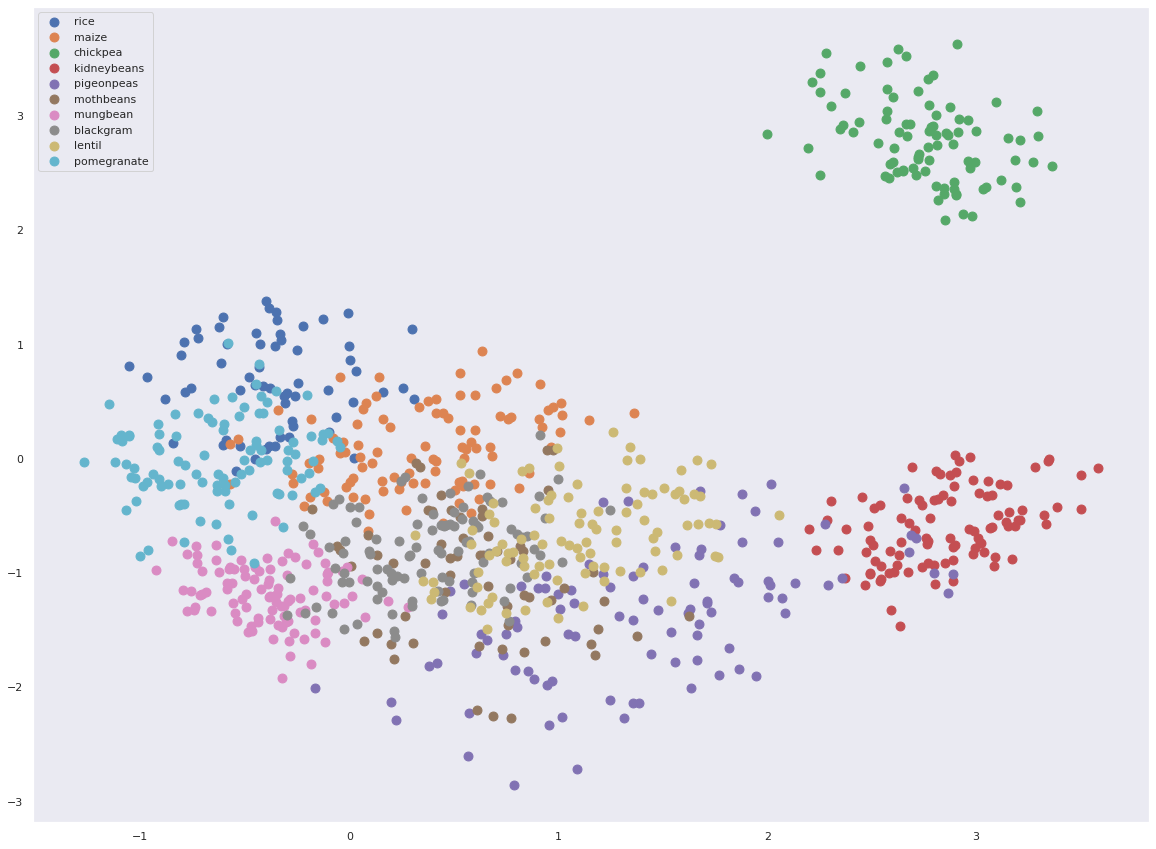

In [77]:
labels = list(pca_df.label.unique())[:10]
plt.figure(figsize=(20,15))
for label in labels:
  idx = pca_df[pca_df.label == label].index
  plt.scatter(pca_df.loc[idx, 'pc1'], pca_df.loc[idx, 'pc2'], label=label, s=80)
plt.grid()
plt.legend()
plt.show()

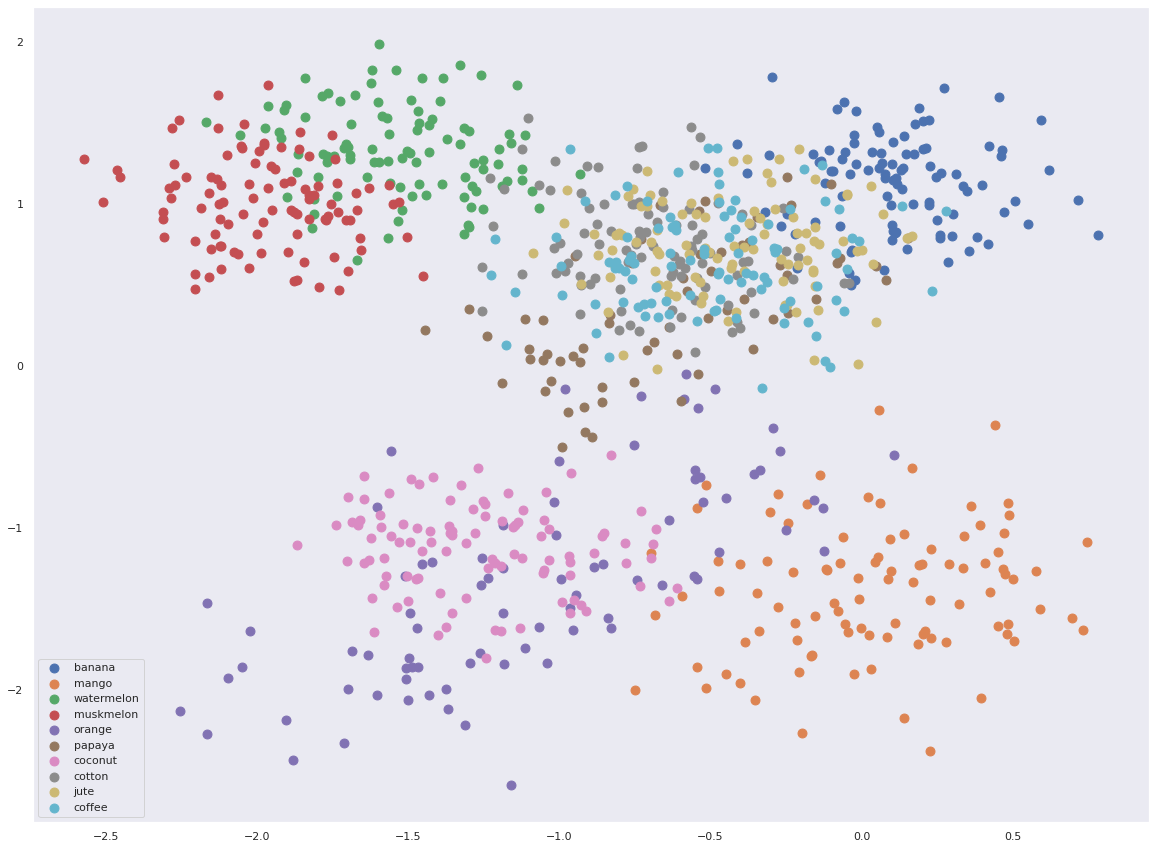

In [78]:
labels = list(pca_df.label.unique())[10:]
plt.figure(figsize=(20,15))
for label in labels:
  idx = pca_df[pca_df.label == label].index
  plt.scatter(pca_df.loc[idx, 'pc1'], pca_df.loc[idx, 'pc2'], label=label, s=80)
plt.grid()
plt.legend()
plt.show()

From the two cluster plots, we can observe that crop do tend to cluster together. Although some crops have a lot of overlap, they could have been easily distinguishable if final dimensions were 3. 

In [79]:
df[cols] = x
encoder = LabelEncoder()
df.label = encoder.fit_transform(df.label)
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,0.943866,-0.140507,0.617341,-1.163084,0.540214,0.014157,1.935598,18
1,0.812004,0.570599,0.496932,-0.948659,0.465882,0.800959,2.388110,18
3,0.521906,-0.451616,0.436727,0.187749,0.458760,0.716127,2.697324,18
7,1.049356,0.348379,0.436727,-1.308004,0.579578,-1.139126,2.680348,18
8,0.917494,0.392823,0.316318,-0.287749,0.607893,0.282292,2.460426,18


In [80]:
X_train, X_test, y_train, y_test = train_test_split(df[cols], df['label'], test_size=0.25)

I have tried developing a recommender model that will predict the best crop based on the soils mineral content and atmospheric factors present. 

---

### 1. Logistic regression


In [81]:
model1 = LogisticRegression(multi_class='multinomial')
model1.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

In [82]:
predictions_1 = model1.predict(X_test)
print(f'Cohen kappa score: {cohen_kappa_score(y_test, predictions_1)}')
print(f'Matthews corr. coeff. score: {matthews_corrcoef(y_test, predictions_1)}')

Cohen kappa score: 0.9588504245591117
Matthews corr. coeff. score: 0.9590450402102805


### 2. Decision Tree

In [83]:
model2 = DecisionTreeClassifier()
model2.fit(X_train, y_train)

DecisionTreeClassifier()

In [84]:
predictions_2 = model2.predict(X_test)
print(f'Cohen kappa score: {cohen_kappa_score(y_test, predictions_2)}')
print(f'Matthews corr. coeff. score: {matthews_corrcoef(y_test, predictions_2)}')

Cohen kappa score: 0.9794259249179857
Matthews corr. coeff. score: 0.9794501616539907


### 3. Random forest

In [85]:
model3 = RandomForestClassifier(criterion='entropy')
model3.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy')

In [86]:
predictions_3 = model3.predict(X_test)
print(f'Cohen kappa score: {cohen_kappa_score(y_test, predictions_3)}')
print(f'Matthews corr. coeff. score: {matthews_corrcoef(y_test, predictions_3)}')

Cohen kappa score: 0.9954280059376547
Matthews corr. coeff. score: 0.9954477119683226


Lets examine which crops are getting the most predictions incorrect. From the cell below, it looks like for certain feature values, rice and jute are unable by the model to be differentiated. Upon further investigation, these two crops have some overlap in feature values which might have caused this error.

In [87]:
for i, j in zip(y_test, predictions_3):
  if i!=j:
    print(f'actual:{i}, {encoder.inverse_transform([i])[0]}, pred:{j}, {encoder.inverse_transform([j])[0]}')

actual:18, rice, pred:6, jute
actual:18, rice, pred:6, jute


Overall, the model is quite accurate with a classification accuracy of 99.5%. Only 2 samples from the test set of 465 samples are predicted incorrectly.